## Coordinate Reference Systems
Geographic vs projected coordinates
The CRS attribute stores the information about the Coordinate Reference System in which the data is represented. In this exercises, we will explore the CRS and the coordinates of the districts dataset about the districts of Paris.

In [2]:
# Import the geopandas library
import geopandas

# Import the districts dataset
districts = geopandas.read_file("paris_districts_utm.geojson")

# Print the CRS information
print(districts.crs)

# Print the first rows of the GeoDataFrame
print(districts.head())

epsg:32631
   id  ...                                           geometry
0   1  ...  POLYGON ((451922.133 5411438.484, 451922.080 5...
1   2  ...  POLYGON ((452278.419 5412160.893, 452192.407 5...
2   3  ...  POLYGON ((451553.806 5412340.522, 451528.058 5...
3   4  ...  POLYGON ((451004.908 5412654.095, 450960.640 5...
4   5  ...  POLYGON ((451328.752 5412991.278, 451294.721 5...

[5 rows x 4 columns]


## Projecting a GeoDataFrame
The Paris districts dataset is provided in geographical coordinates (longitude/latitude in WGS84). To see the result of naively using the data as is for plotting or doing calculations, we will first plot the data as is, and then plot a projected version.

The standard projected CRS for France is the RGF93 / Lambert-93 reference system (referenced by the EPSG:2154 number).

epsg:32631


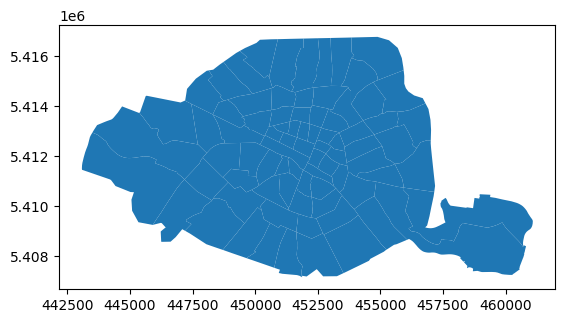

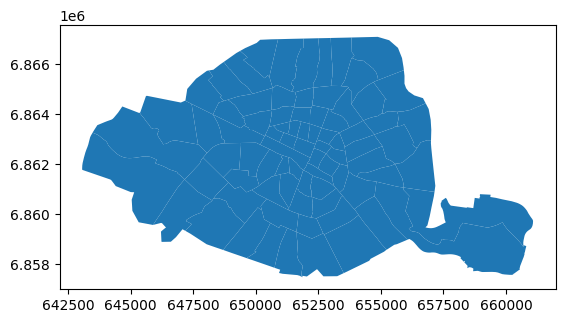

In [5]:
# Print the CRS information
print(districts.crs)

# Plot the districts dataset
districts.plot()

# Import the matplotlib.pyplot library
import matplotlib.pyplot as plt

# Show the plot
plt.show()

# Convert the districts to the RGF93 reference system
districts_RGF93 = districts.to_crs(epsg=2154)

# Plot the districts dataset again
districts_RGF93.plot()

# Show the plot
plt.show()

## Projecting a Point
Shapely geometry objects have no notion of a CRS, and thus cannot be directly converted to another CRS. Therefore, we are going to use the GeoPandas to transform the Eiffel Tower point location to an alternative CRS. We will put the single point in a GeoSeries, use the to_crs() method, and extract the point again.

In [6]:
# Construct a Point object for the Eiffel Tower
from shapely.geometry import Point
eiffel_tower = Point(2.2945, 48.8584)

# Put the point in a GeoSeries with the correct CRS
s_eiffel_tower = geopandas.GeoSeries([eiffel_tower], crs={'init': 'epsg:4326'})

# Convert to other CRS
s_eiffel_tower_projected = s_eiffel_tower.to_crs(epsg=2154)

# Print the projected point
print(s_eiffel_tower_projected)

0    POINT (648237.302 6862271.682)
dtype: geometry


## Calculating distance in a projected CRS
Now we have the Eiffel Tower location in a projected coordinate system, we can calculate the distance to other points.

The final s_eiffel_tower_projected of the previous exercise containing the projected Point is already provided, and we extract the single point into the eiffel_tower variable. 

In [8]:
import pandas as pd
paris_restaurants = pd.read_csv('paris_restaurants.csv')
paris_restaurants

,type,x,y
0,European restuarant,259641.691646,6.251867e+06
1,Traditional French restaurant,259572.339603,6.252030e+06
2,Traditional French restaurant,259657.276374,6.252143e+06
3,Indian / Middle Eastern restaurant,259684.438330,6.252203e+06
4,Traditional French restaurant,259597.943086,6.252230e+06
...,...,...,...
5730,Asian restaurant,259415.267801,6.253554e+06
5731,European restuarant,259039.341881,6.253967e+06
5732,Asian restaurant,267737.067655,6.251037e+06
5733,Maghrebian restaurant,267811.874353,6.250977e+06


In [ ]:
# Extract the single Point
eiffel_tower = s_eiffel_tower_projected[0]

# Ensure the restaurants use the same CRS
restaurants = restaurants.to_crs(s_eiffel_tower_projected.crs)

# The distance from each restaurant to the Eiffel Tower
dist_eiffel = restaurants.distance(eiffel_tower)

# The distance to the closest restaurant
print(dist_eiffel.min())

In [ ]:
<script.py> output:
    303.56255387792174

## Projecting to Web Mercator for using web tiles

Currently, contextily assumes that your data is in the Web Mercator projection, the system used by most web tile services. And in that first exercise, we provided the data in the appropriate CRS so you didn't need to care about this aspect.

However, typically, your data will not come in Web Mercator (EPSG:3857) and you will have to align them with web tiles on your own.

In [ ]:
# Convert to the Web Mercator projection
restaurants_webmercator = restaurants.to_crs(crs=CRS.from_epsg(3857))

# Plot the restaurants with a background map
ax = restaurants_webmercator.plot(markersize=1)
contextily.add_basemap(ax)
plt.show()

![resim_2023-03-24_225947650](resim_2023-03-24_225947650.png)


In [ ]:
# Import the land use dataset
land_use = geopandas.read_file("paris_land_use.shp")
print(land_use.head())

# Make a plot of the land use with 'class' as the color
land_use.plot(column='class', legend=True, figsize=(15, 10))
plt.show()

# Add the area as a new column
land_use['area'] = land_use.geometry.area

# Calculate the total area for each land use class
total_area = land_use.groupby('class')['area'].sum() / 1000**2
print(total_area)

![resim_2023-03-24_232559025](resim_2023-03-24_232559025.png)


## Intersection of two polygons
For this exercise, we are going to use 2 individual polygons: the district of Muette extracted from the districts dataset, and the green urban area of Boulogne, a large public park in the west of Paris, extracted from the land_use dataset. The two polygons have already been assigned to the muette and park_boulogne variables.

We first visualize the two polygons. You will see that they overlap, but the park is not fully located in the district of Muette.

In [ ]:
# Plot the two polygons
geopandas.GeoSeries([park_boulogne, muette]).plot(alpha=0.5, color=['green', 'blue'])
plt.show()

# Calculate the intersection of both polygons
intersection = park_boulogne.intersection(muette)

# Plot the intersection
geopandas.GeoSeries([intersection]).plot()
plt.show()

# Print proportion of district area that occupied park
print(intersection.area / muette.area)

In [ ]:
<script.py> output:
    0.4352082235641065

![resim_2023-03-24_232813420](resim_2023-03-24_232813420.png)


## Intersecting a GeoDataFrame with a Polygon
Combining the land use dataset and the districts dataset, we can now investigate what the land use is in a certain district.

In [ ]:
# Print the land use datset and Notre-Dame district polygon
print(land_use.head())
print(type(muette))

# Calculate the intersection of the land use polygons with Notre Dame
land_use_muette = land_use.geometry.intersection(muette)

# Plot the intersection
land_use_muette.plot(edgecolor='black')
plt.show()

# Print the first five rows of the intersection
print(land_use_muette.head())

In [ ]:
<script.py> output:
                                class                                           geometry
    0  Industrial, commercial, public  POLYGON ((3751385.614 2895114.545, 3751395.345...
    1                    Water bodies  POLYGON ((3751386.281 2890064.323, 3751395.345...
    2       Roads and associated land  POLYGON ((3751390.345 2886000.000, 3751390.345...
    3       Roads and associated land  POLYGON ((3751390.345 2886898.192, 3751390.370...
    4       Roads and associated land  POLYGON ((3751390.345 2887500.000, 3751390.345...
    <class 'shapely.geometry.polygon.Polygon'>
    0    POLYGON EMPTY
    1    POLYGON EMPTY
    2    POLYGON EMPTY
    3    POLYGON EMPTY
    4    POLYGON EMPTY
    dtype: geometry

![resim_2023-03-24_233017785](resim_2023-03-24_233017785.png)


## Overlay of two polygon layers

In [ ]:
# Print the first five rows of both datasets
print(land_use.head())
print(districts.head())

# Overlay both datasets based on the intersection
combined = geopandas.overlay(land_use, districts, how='intersection')

# Print the first five rows of the result
print(combined.head())

In [ ]:
<script.py> output:
                                class                                           geometry
    0  Industrial, commercial, public  POLYGON ((3751385.614 2895114.545, 3751395.345...
    1                    Water bodies  POLYGON ((3751386.281 2890064.323, 3751395.345...
    2       Roads and associated land  POLYGON ((3751390.345 2886000.000, 3751390.345...
    3       Roads and associated land  POLYGON ((3751390.345 2886898.192, 3751390.370...
    4       Roads and associated land  POLYGON ((3751390.345 2887500.000, 3751390.345...
       id           district_name  population                                           geometry
    0   1  St-Germain-l'Auxerrois        1672  POLYGON ((3760188.135 2889260.457, 3760188.075...
    1   2                  Halles        8984  POLYGON ((3760610.022 2889946.422, 3760503.163...
    2   3            Palais-Royal        3195  POLYGON ((3759905.524 2890194.454, 3759873.112...
    3   4           Place-Vendôme        3044  POLYGON ((3759388.396 2890559.229, 3759334.824...
    4   5                 Gaillon        1345  POLYGON ((3759742.125 2890864.394, 3759698.189...
                           class  id district_name  population  \
    0               Water bodies  61       Auteuil       67967   
    1    Continuous Urban Fabric  61       Auteuil       67967   
    2  Roads and associated land  61       Auteuil       67967   
    3          Green urban areas  61       Auteuil       67967   
    4  Roads and associated land  61       Auteuil       67967   
    
                                                geometry  
    0  POLYGON ((3751395.345 2890118.001, 3751395.345...  
    1  MULTIPOLYGON (((3753253.104 2888254.529, 37532...  
    2  POLYGON ((3751519.830 2890061.509, 3751522.057...  
    3  MULTIPOLYGON (((3754314.717 2890283.121, 37543...  
    4  POLYGON ((3751619.113 2890500.000, 3751626.627...  

In [ ]:
# Print the first rows of the overlay result
print(combined.head())

# Add the area as a column
combined['area'] = combined.geometry.area

# Take a subset for the Muette district
land_use_muette = combined[combined['district_name'] == 'Muette']

# Visualize the land use of the Muette district
land_use_muette.plot(column='class')
plt.show()

# Calculate the total area for each land use class
print(land_use_muette.groupby('class')['area'].sum() / 1000**2)

In [ ]:
<script.py> output:
                           class  id district_name  population  \
    0               Water bodies  61       Auteuil       67967   
    1    Continuous Urban Fabric  61       Auteuil       67967   
    2  Roads and associated land  61       Auteuil       67967   
    3          Green urban areas  61       Auteuil       67967   
    4  Roads and associated land  61       Auteuil       67967   
    
                                                geometry  
    0  POLYGON ((3751395.345 2890118.001, 3751395.345...  
    1  MULTIPOLYGON (((3753253.104 2888254.529, 37532...  
    2  POLYGON ((3751519.830 2890061.509, 3751522.057...  
    3  MULTIPOLYGON (((3754314.717 2890283.121, 37543...  
    4  POLYGON ((3751619.113 2890500.000, 3751626.627...  
    class
    Continuous Urban Fabric             1.275
    Discontinuous Dense Urban Fabric    0.088
    Green urban areas                   2.624
    Industrial, commercial, public      0.363
    Railways and associated land        0.005
    Roads and associated land           0.226
    Sports and leisure facilities       0.604
    Water bodies                        0.292
    Name: area, dtype: float64

![resim_2023-03-24_233747195](resim_2023-03-24_233747195.png)
